In [1]:
from neurotron import Attribute, Matrix, Cluster
from neurotron import Ansi, Monitor, Cell, Record, isa
import neurotron.math as nm


In [2]:
#===========================================================================
# helper: check cell's movie with given pattern
#===========================================================================

def check(cells,pattern):
    """
    check(): check recorder pattern of a network of cells against a given
             pattern and raise exception if check fails.
    >>> par,token = toy('sarah')
    >>> cells = Cells(3,par,[3,10])
    >>> y = cells.iteration([0,0,0]+token['Sarah'])
    >>> check(cells,'|U,U,QB,QBY,DY,D--|---D,XD,X,X,X|---D,D---|')
    """
    p = cells.record.pattern()
    if p != pattern:
        print('expected: ',pattern)
        print('got:      ',p)
        raise Exception('pattern check failed')



In [3]:
class Synapse(Exception):
    """
    class Synapse: exception to raise if there are no more free synapses
    """
    pass

class Cells(Cluster):
    def __init__(self,shape,token=None):
        nm.seed(1)
        cells = super().__init__(*shape,verbose=1)
        self.token = token
        m,n,d,s = shape
        f = [0,0,0] if token is None else token['.']
        self.y = nm.row(nm.zeros(1,m*n),f)
        self.record = Record(self)

    def process(self,word):
        m,n,d,s = self.shape
        mon = Monitor(m,n);
        self.y = nm.row(nm.zeros(1,m*n),token[word])
        self.y = self.step(mon,self.y,word)
        output,predict = self.decode()
        mon.xlabel((n-1)/2,output+' -> '+predict)

    def predictive(self,list):
        for k in list:
            cells.X[k] = 1;
            cells._predict.I[k] = Matrix([[.1,-.1,.1,-.1,.1],[0,0,0,0,0]])

    def __str__(self):
        self.record.clear();  
        self.record(self)
        return self.record.pattern()

    def __repr__(self):
        return self.__str__()

    def connect(self,idx,kdx):
        """
        >>> cells = Cells()
        >>> cells.connect([0,14,16,12,12],[2])
        """
        assert isa(idx,list)
        assert isa(kdx,list)
        m,n,d,s = self.shape
        if len(idx) > s: 
            raise Exception('more than %g indices provided (arg2)'%s)
        predict = self._predict

        for k in kdx:
            done = False
            for ii in range(d):
                if nm.all(predict.P[k][ii,:]==0):
                    for jj in range(s):
                        predict.K[k][ii,jj] = 0
                    for jj in range(len(idx)):
                        predict.K[k][ii,jj] = idx[jj]
                        predict.P[k][ii,jj] = 0.5
                    done = True
                    break
            if not done:
                print('K[%g]' % k, predict.K[k])
                raise Synapse('no free synapses to connect: [%g]'%k)

    def decode(self):
        m,n,d,s = self.shape
        output = predict = '???'
        for key in self.token:
            pattern = self.token[key]
            xok = yok = True
            for j in range(n):
                if nm.any(self.X[:,j]) != pattern[j]: xok = False
                if nm.any(self.Y[:,j]) != pattern[j]: yok = False
            if yok: output = key
            if xok: predict = key
            #print('key:',key,'pattern:',pattern,'ok:',(yok,xok))
        return (output,predict)
        

In [34]:
#=========================================================================
# class Token
#=========================================================================

class Token(dict):
    def __init__(self, *args, **kwargs):
        super(Token, self).__init__(*args, **kwargs)
        self._init()

    def pattern(self,list):
        """
        >>> Token().pattern([1,0,1,0])
        '1010'
        """
        str = ''
        for item in list: str += '1' if item else '0'
        return str

    def _init(self):
        self._decoder = {}  # inverse map's dictionary
        for key in self: 
            pat = self.pattern(self[key])
            self._decoder[pat] = key

    def decode(self,arg=None):
        """
        >>> token = Token({'word1':[0,1,0],'word2':[1,0,1]})
        >>> token.decode([0,1,0])
        'word1'
        >>> token.decode(Matrix([[1,0,0],[0,0,1]]))
        'word2'
        """
        if arg is None:
            return token._decoder
        elif isa(arg,list):
            return self._decoder[self.pattern(arg)]
        elif isa(arg,Matrix):
            row = nm.max(arg).list()
            return self._decoder(row)
        else:
            raise Exception('unsupported arg type')

Token().pattern([1,0,1,0])
token = Token({'word1':[0,1,0],'word2':[1,0,1]})
print(token.decode())
print(token.decode([0,1,0]))
token.decode(Matrix([[1,0,0],[0,0,1]]))
        

{'010': 'word1', '101': 'word2'}
word1


AttributeError: 'Matrix' object has no attribute 'list'

In [32]:
#=========================================================================
# setup network
#=========================================================================

token = Token({'Mary': [1,0,0,0,0,0,0,1,1],
               'John': [0,1,0,0,0,0,0,1,1],
               'Lisa': [1,0,0,0,0,0,1,1,0],
               'Andy': [0,1,0,0,0,0,1,1,0],
               'likes':[0,0,1,0,0,0,0,1,1],
               'to':   [0,0,0,1,0,0,0,1,1],
               'sing': [0,0,0,0,1,0,0,1,1],
               'dance':[0,0,0,0,0,1,0,1,1],
               'hike': [0,0,0,0,1,0,1,1,0],
               'climb':[0,0,0,0,1,0,1,0,1],
               '.':    [0,0,0,0,0,0,1,1,1],
              })
    
def setup(token):
    shape = (2,9,8,3);  
    #print('##### token:',token)
    cells = Cells(shape,token)
    cells._predict.clear()

    try:
        cells.connect([0,14,16],[4,14,16])  # Mary -> likes
        cells.connect([4,14,16],[6,14,16])  # likes -> to
        cells.connect([6,14,16],[8,14,16])  # to -> sing
        cells.connect([8,14,16],[12,14,16]) # sing -> .

        cells.connect([2,14,16],[5,15,17])  # John -> likes  
        cells.connect([5,15,17],[7,15,17])  # likes -> to
        cells.connect([7,15,17],[10,15,17]) # to(7,15,17) -> dance(10,15,17)
        cells.connect([10,15,17],[13,15,17])# dance -> .

        cells.connect([0,12,14],[4,14,17])  # Lisa -> likes
        cells.connect([4,14,17],[6,15,16])  # likes -> to
        cells.connect([6,15,16],[8,12,14])  # to -> hike
        cells.connect([8,12,14],[13,15,17]) # hike -> .

        cells.connect([2,12,14],[5,14,17])  # Andy -> likes
        cells.connect([5,14,17],[7,15,16])  # likes -> to
        cells.connect([7,15,16],[9,12,16])  # to -> climb
        cells.connect([9,12,16],[13,15,17]) # climb -> .
    except Synapse as s:
        print(Ansi.R,'*** warning:',str(s),Ansi.N)
        
    return cells

cells = setup(token)


mind I[5].1: [0.1 0.1 0.1]
mind I[14].6: [0.1 0.1 0.1]
mind I[17].6: [0.1 0.1 0.1]


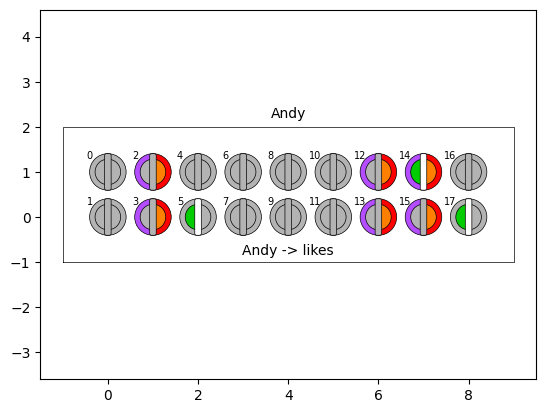

In [6]:
cells.process('Andy')

learn P[5].1: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[14].6: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[17].6: [0.6 0.6 0.6] by [0.1 0.1 0.1]
mind I[7].1: [0.1 0.1 0.1]
mind I[15].6: [0.1 0.1 0.1]
mind I[16].5: [0.1 0.1 0.1]


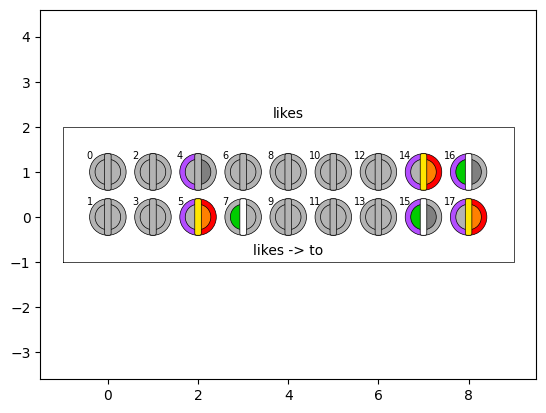

In [7]:
cells.process('likes')

learn P[7].1: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[15].6: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[16].5: [0.6 0.6 0.6] by [0.1 0.1 0.1]
mind I[9].0: [0.1 0.1 0.1]
mind I[12].2: [0.1 0.1 0.1]
mind I[16].6: [0.1 0.1 0.1]


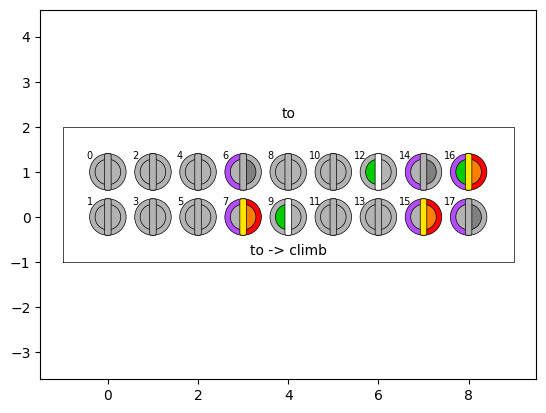

In [8]:
cells.process('to')

learn P[9].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[12].2: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[16].6: [0.6 0.6 0.6] by [0.1 0.1 0.1]
mind I[13].2: [0.1 0.1 0.1]
mind I[15].7: [0.1 0.1 0.1]
mind I[17].7: [0.1 0.1 0.1]


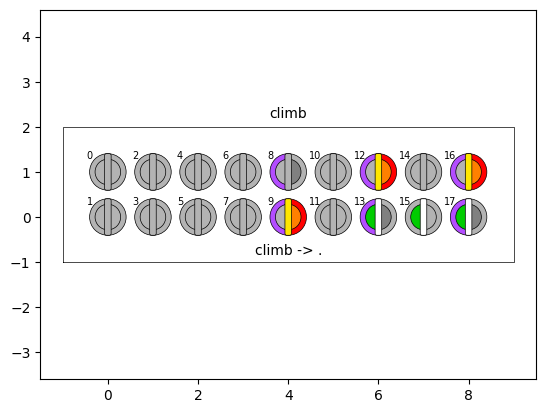

In [9]:
cells.process('climb')

learn P[13].2: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[15].7: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[17].7: [0.6 0.6 0.6] by [0.1 0.1 0.1]


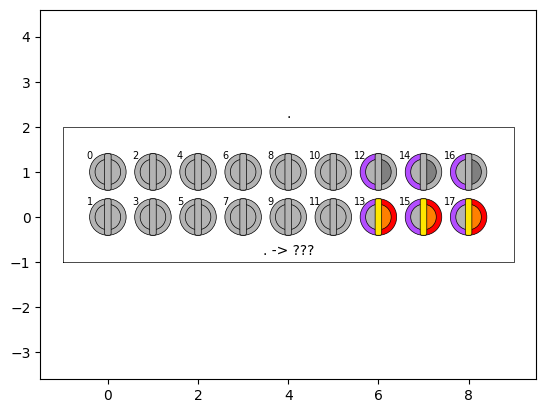

In [10]:
cells.process('.')

mind I[4].0: [0.1 0.1 0.1]
mind I[14].0: [0.1 0.1 0.1]
mind I[16].0: [0.1 0.1 0.1]


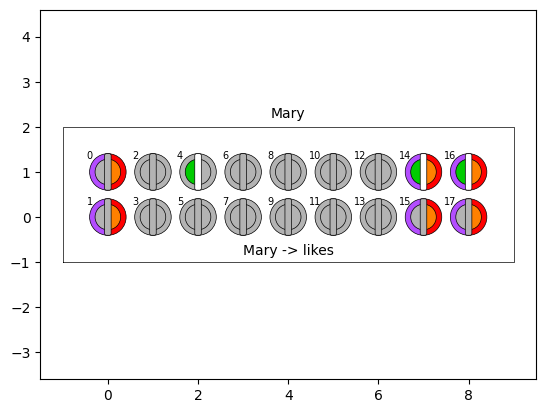

In [11]:
cells.process('Mary')
#check(cells,'|UQBY|UQBY|-|-|XS|-|-|-|-|-|-|-|-|-|UQBY|UQBY|UQBY|UQBY|')

learn P[4].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[14].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[16].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]
mind I[6].0: [0.1 0.1 0.1]
mind I[14].1: [0.1 0.1 0.1]
mind I[16].1: [0.1 0.1 0.1]


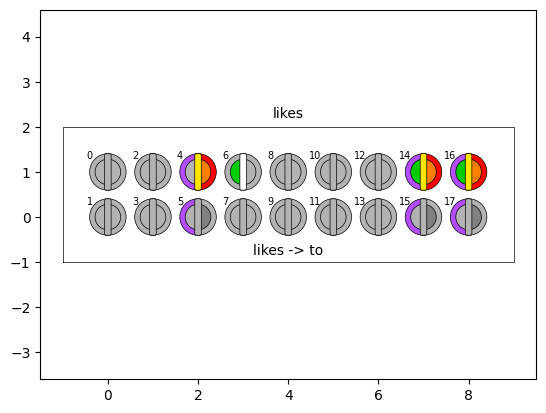

In [12]:
cells.process('likes')

learn P[6].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[14].1: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[16].1: [0.6 0.6 0.6] by [0.1 0.1 0.1]
mind I[8].0: [0.1 0.1 0.1]
mind I[14].2: [0.1 0.1 0.1]
mind I[16].2: [0.1 0.1 0.1]


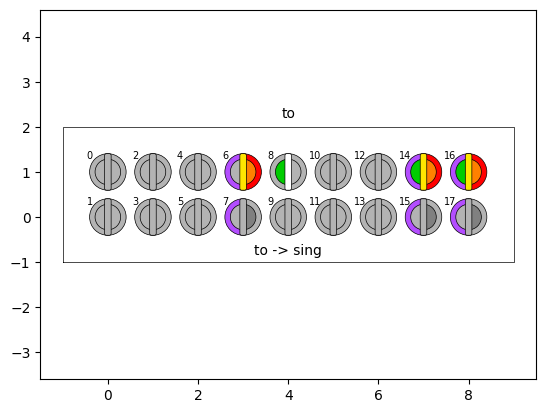

In [12]:
cells.process('to')

learn P[8].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[14].2: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[16].2: [0.6 0.6 0.6] by [0.1 0.1 0.1]
mind I[12].0: [0.1 0.1 0.1]
mind I[14].3: [0.1 0.1 0.1]
mind I[16].3: [0.1 0.1 0.1]


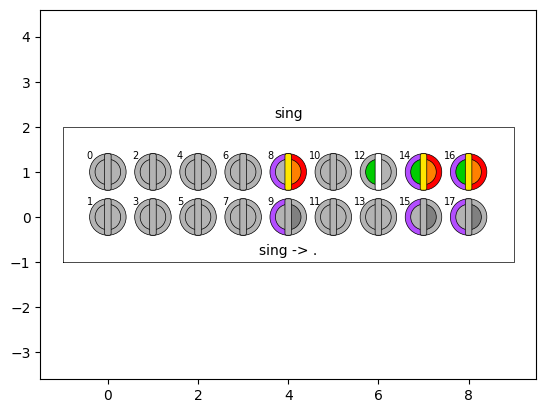

In [13]:
cells.process('sing')

learn P[12].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[14].3: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[16].3: [0.6 0.6 0.6] by [0.1 0.1 0.1]


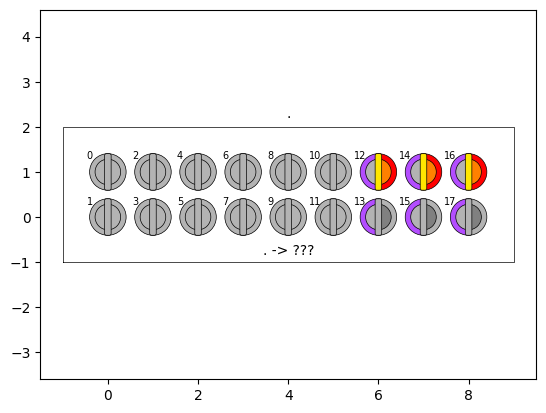

In [14]:
cells.process('.')

mind I[5].0: [0.1 0.1 0.1]
mind I[15].0: [0.1 0.1 0.1]
mind I[17].0: [0.1 0.1 0.1]


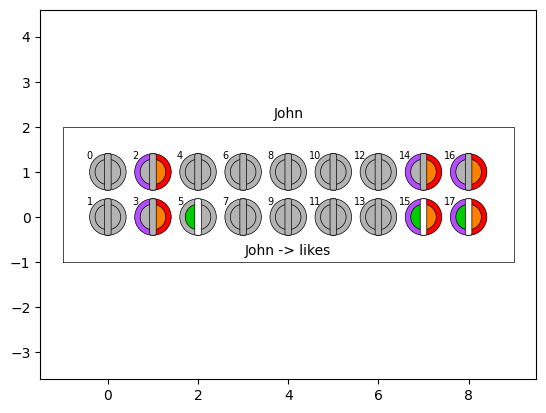

In [15]:
cells.process('John')

learn P[5].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[15].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[17].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]
mind I[7].0: [0.1 0.1 0.1]
mind I[15].1: [0.1 0.1 0.1]
mind I[17].1: [0.1 0.1 0.1]


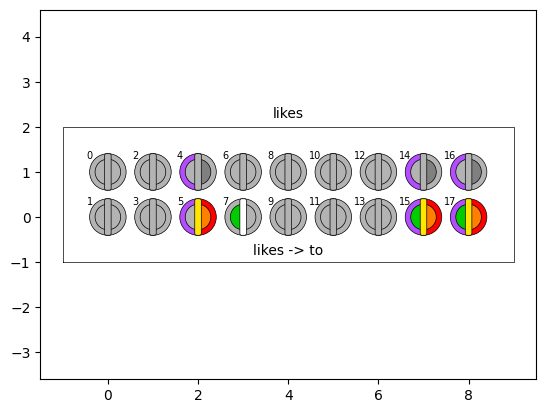

In [16]:
cells.process('likes')

learn P[7].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[15].1: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[17].1: [0.6 0.6 0.6] by [0.1 0.1 0.1]
mind I[10].0: [0.1 0.1 0.1]
mind I[15].2: [0.1 0.1 0.1]
mind I[17].2: [0.1 0.1 0.1]


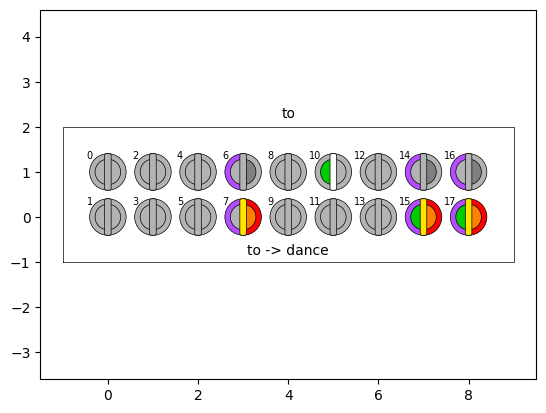

In [17]:
cells.process('to')

learn P[10].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[15].2: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[17].2: [0.6 0.6 0.6] by [0.1 0.1 0.1]
mind I[13].0: [0.1 0.1 0.1]
mind I[15].3: [0.1 0.1 0.1]
mind I[17].3: [0.1 0.1 0.1]


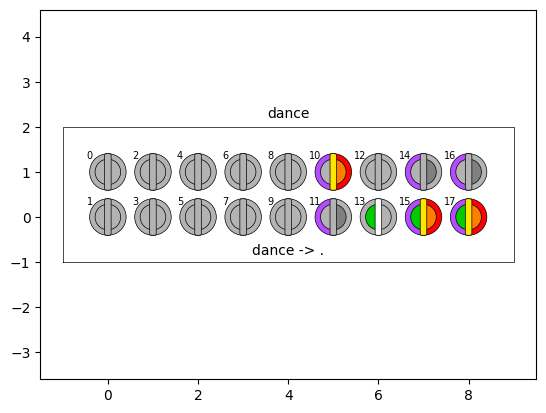

In [18]:
cells.process('dance')

learn P[13].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[15].3: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[17].3: [0.6 0.6 0.6] by [0.1 0.1 0.1]


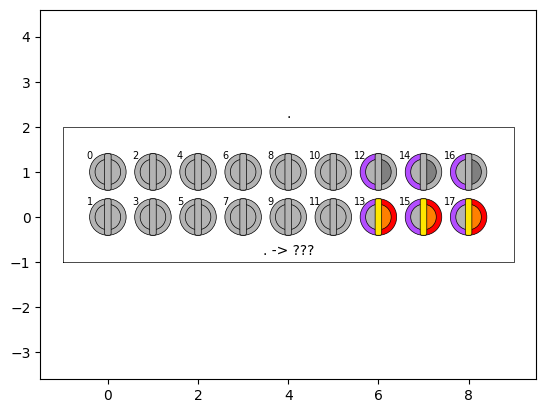

In [19]:
cells.process('.')

mind I[4].1: [0.1 0.1 0.1]
mind I[14].4: [0.1 0.1 0.1]
mind I[17].4: [0.1 0.1 0.1]


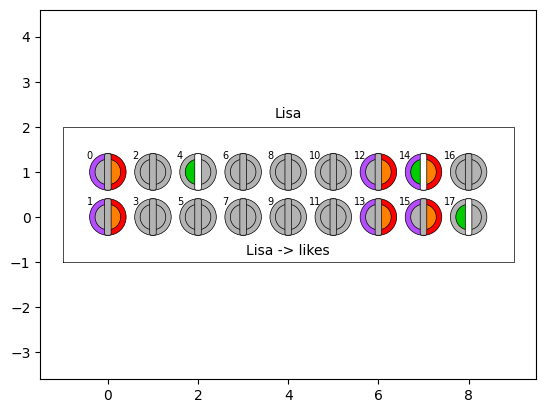

In [20]:
cells.process('Lisa')

learn P[4].1: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[14].4: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[17].4: [0.6 0.6 0.6] by [0.1 0.1 0.1]
mind I[6].1: [0.1 0.1 0.1]
mind I[15].4: [0.1 0.1 0.1]
mind I[16].4: [0.1 0.1 0.1]


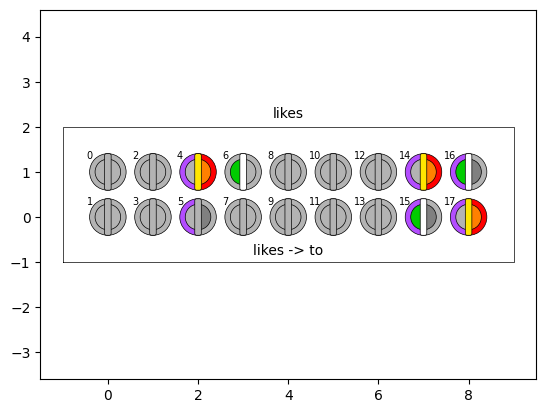

In [21]:
cells.process('likes')

learn P[6].1: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[15].4: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[16].4: [0.6 0.6 0.6] by [0.1 0.1 0.1]
mind I[8].1: [0.1 0.1 0.1]
mind I[12].1: [0.1 0.1 0.1]
mind I[14].5: [0.1 0.1 0.1]


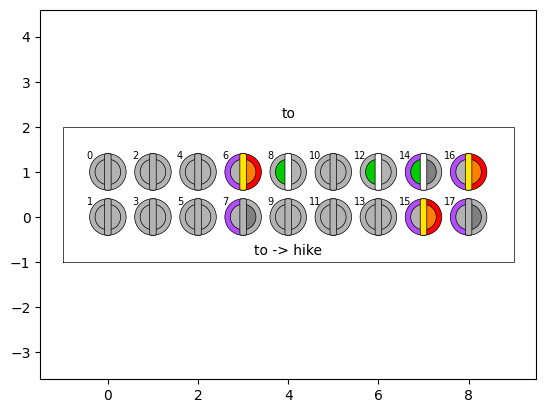

In [22]:
cells.process('to')

learn P[8].1: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[12].1: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[14].5: [0.6 0.6 0.6] by [0.1 0.1 0.1]
mind I[13].1: [0.1 0.1 0.1]
mind I[15].5: [0.1 0.1 0.1]
mind I[17].5: [0.1 0.1 0.1]


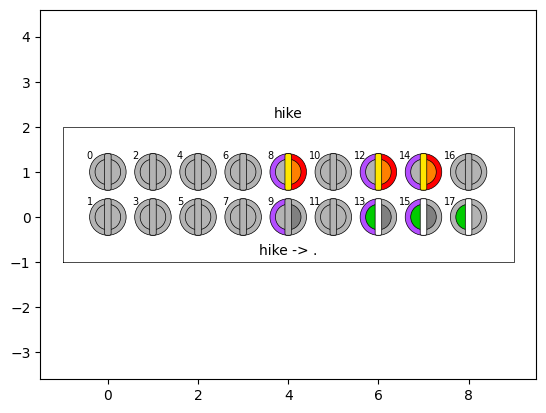

In [23]:
cells.process('hike')

learn P[13].1: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[15].5: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[17].5: [0.6 0.6 0.6] by [0.1 0.1 0.1]


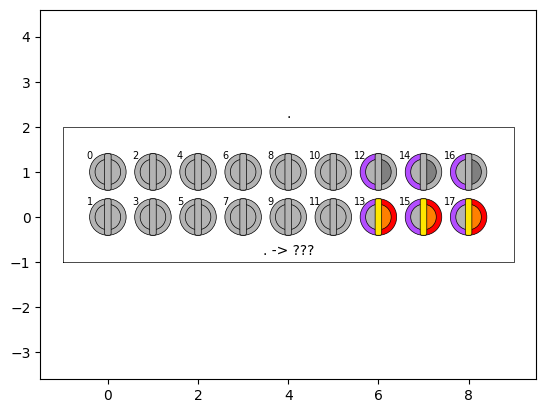

In [24]:
cells.process('.')